In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import random
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
from pprint import pprint

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# fix random number generation aka regenerate the same random numbers every time (such as weight and bias initialization )
def set_random_seed(seed=7, deterministic=True):
    """Set random seed, for python, numpy, pytorch

    Args:
        seed (int): Seed to be used.
        deterministic (bool): Whether to set the deterministic option for
            CUDNN backend, i.e., set `torch.backends.cudnn.deterministic`
            to True and `torch.backends.cudnn.benchmark` to False.
            Default: True.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False 
seed=7        
set_random_seed(seed=seed)

In [3]:
df = pd.read_csv("../data/data.csv")
df.head(7)

,weekday_name,month,leap_year_condition,decade,output,output_year_digit,output_year,valid_years_list,valid_day_list,decade4,decade100,decade400,valid_group_days_index
0,2,1,0,180,1-1-1800,0,1800,"[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1,7
1,3,1,0,180,1-1-1801,1,1801,"[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1,7
2,4,1,0,180,1-1-1802,2,1802,"[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1,7
3,5,1,0,180,1-1-1803,3,1803,"[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1,7
4,6,1,1,180,1-1-1804,4,1804,"[4, 8, 4, 4, 4, 4, 4, 4]","[1, 8, 15, 22, 29]",0,0,1,7
5,1,1,0,180,1-1-1805,5,1805,"[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1,7
6,2,1,0,180,1-1-1806,6,1806,"[0, 1, 2, 3, 5, 6, 7, 9]","[1, 8, 15, 22, 29]",0,0,1,7


- given the columns features we can't by any means diffrentiate between the day 1 or day 8 or 15 or 22 or 28 because they may share the same exact feature columns values and they all still correct, and the model see them all as the same thing, so i make lists for the identical days from the feature columns point of view, and instead of training the model to select certain day, i trained the model to select index of days-list which i named "groups", as example if the output of the model is 0 then it equivalent to selecting any day from these days [1, 8, 15, 22], if the output is 1 so it's equivalent to selecting any number from [2, 9, 16, 23] and so on(see groups_dict dictionary)

In [4]:
# list of all possibole (10) output lists, the output must be one of theses lists
groups = [[1, 8, 15, 22], 
         [2, 9, 16, 23], 
         [3, 10, 17, 24], 
         [4, 11, 18, 25], 
         [5, 12, 19, 26], 
         [6, 13, 20, 27], 
         [7, 14, 21, 28],
         [1, 8, 15, 22, 29], 
         [2, 9, 16, 23, 30], 
         [3, 10, 17, 24, 31]]
groups_dict = dict(enumerate(groups))
groups_dict

{0: [1, 8, 15, 22],
 1: [2, 9, 16, 23],
 2: [3, 10, 17, 24],
 3: [4, 11, 18, 25],
 4: [5, 12, 19, 26],
 5: [6, 13, 20, 27],
 6: [7, 14, 21, 28],
 7: [1, 8, 15, 22, 29],
 8: [2, 9, 16, 23, 30],
 9: [3, 10, 17, 24, 31]}

**B- training for getting the day**

In [5]:
df[["weekday_name", "month", "output_year", "leap_year_condition", "valid_group_days_index"]].head()

,weekday_name,month,output_year,leap_year_condition,valid_group_days_index
0,2,1,1800,0,7
1,3,1,1801,0,7
2,4,1,1802,0,7
3,5,1,1803,0,7
4,6,1,1804,1,7


**it's obvious that values if the output_year column is very high, and if i train the model this column will dominate the calculations, i need to make standardrization or normalization step, but as i need this value as it, i will do another thing, i will divide this column into two columns, century column and year column to reduce the influence of this column over the network**

In [6]:
# first try
# df["century"] = df.output_year//100
# df["century_decade"] = (df.output_year//10)-(df["century"]*10)
# df["decade_year"] = df.output_year-(df.output_year//10)*10
# df["century"] = df.century-df.century.min()
# x_day = df[["weekday_name", "month", "century", "century_decade", "decade_year", "leap_year_condition", "valid_group_days_index"]]
# df["century"].unique(), df["decade_year"].unique(), df["century_decade"].unique()

In [7]:
# second try
# df["century"] = df.output_year//100
# df["century_year"] = df.output_year-df["century"]*100
# df["century_year"] = df["century_year"]#/10
# df["century"] = df.century-df.century.min()
# x_day = df[["weekday_name", "month", "century", "century_year", "leap_year_condition", "valid_group_days_index"]]
# df["century"].unique(), df["century_year"].unique()

In [8]:
# i used the equation on that site https://artofmemory.com/blog/how-to-calculate-the-day-of-the-week/
# to make new engineered feature, to help me increase the accuracy from 28% up to it's current value

month_dict = {1:0, 2:3, 3:3, 4:6, 5:1, 6:4, 7:6, 8:2, 9:5, 10:0, 11:3, 12:5}
century_dict = {17:4, 18:2, 19:0, 20:6, 21:4, 22:2, 23:0}

df["century_code"] = [century_dict[val] for val in (df.output_year//100)]

df["month_code"] = [month_dict[val] for val in df.month]

df["year_code"] = (df.output_year%100)
df["year_code"] = ((df["year_code"]//4)+df["year_code"])%7


x_day = df[["weekday_name", "month", "month_code", "century_code", "year_code", "leap_year_condition", "valid_group_days_index"]]
x_day.head()

,weekday_name,month,month_code,century_code,year_code,leap_year_condition,valid_group_days_index
0,2,1,0,2,0,0,7
1,3,1,0,2,1,0,7
2,4,1,0,2,2,0,7
3,5,1,0,2,3,0,7
4,6,1,0,2,5,1,7


In [9]:
y_day = x_day.pop("valid_group_days_index") # from 0 to 9

7    22540
8    22055
3    19248
4    19248
5    19248
6    19248
9    14035
2     8020
1     1604
0     1216
Name: valid_group_days_index, dtype: int64


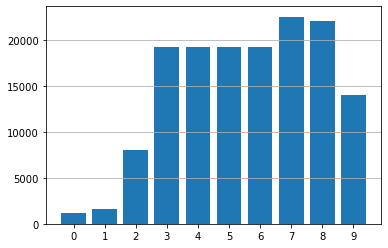

In [10]:
pprint(df.valid_group_days_index.value_counts())
plt.bar(df.valid_group_days_index.value_counts().index, df.valid_group_days_index.value_counts())
plt.xticks(range(10))
plt.grid(axis="y")
plt.show()

**the output column is imbalanced**

In [11]:
# splitting the data
xtrain_day, xtest_day, ytrain_day, ytest_day = train_test_split(x_day, y_day, 
                                                                test_size=0.19, 
                                                                shuffle=True, 
                                                                random_state=seed, 
                                                                stratify=df.valid_group_days_index)

# make oversampling to fix the imbalanced classes
ros = RandomOverSampler(random_state=7)
x_day_train_sampld, y_day_train_sampld = ros.fit_resample(xtrain_day, ytrain_day)

In [12]:
print(f"ytrain_day = {len(ytrain_day)//1000}k,\nytest_day = {len(ytest_day)//1000}k, \ny_day_train_sampld = {len(x_day_train_sampld)//1000}k")

ytrain_day = 118k,
ytest_day = 27k, 
y_day_train_sampld = 182k


6    18257
9    18257
5    18257
2    18257
4    18257
8    18257
7    18257
3    18257
1    18257
0    18257
Name: valid_group_days_index, dtype: int64


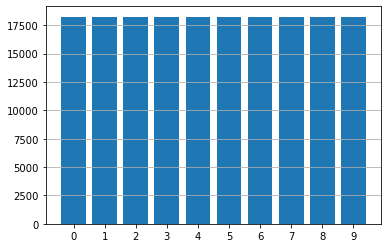

In [13]:
#**after oversampling**
pprint(y_day_train_sampld.value_counts())
plt.bar(y_day_train_sampld.value_counts().index, y_day_train_sampld.value_counts())
plt.xticks(range(10))
plt.grid(axis="y")
plt.show()

In [14]:
class CollectedData(Dataset):
    def __init__(self, x, y):
        self.data = torch.tensor(x.values.astype(np.float32))
        self.label = torch.tensor(y.values)
        self.n_smpl = x.shape[0]
        
        
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
    def __len__(self):
        return self.n_smpl    
    
train_set_day = CollectedData(x_day_train_sampld, y_day_train_sampld)
test_set_day = CollectedData(xtest_day, ytest_day)    

In [15]:
## random_split() isn't suitable here, so that i used train_test_split function
# # train_set, test_set = torch.utils.data.random_split(dataset, [len(dataset)-test_len, int(len(dataset)*0.2)])

# train_labels_day = torch.tensor(ytrain_day.values.astype(np.float32)) 
# test_labels_day = torch.tensor(ytest_day.values.astype(np.float32)) 
# train_input_day = torch.tensor(xtrain_day.values.astype(np.float32)) 
# test_input_day = torch.tensor(xtest_day.values.astype(np.float32)) 

# train_set_day = TensorDataset(train_input_day, train_labels_day)
# test_set_day = TensorDataset(test_input_day, test_labels_day)


In [16]:
batch_size = 128

train_loader_day = DataLoader(dataset=train_set_day, shuffle=True, batch_size=batch_size)
test_loader_day = DataLoader(dataset=test_set_day, batch_size=batch_size) 

In [17]:
class network(nn.Module):
    def __init__(self, in_features=5, out_features=10):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 24)
        self.fc2 = nn.Linear(24, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 14)
        self.fc5 = nn.Linear(14, out_features) 
        self.initialize_weights()
        
        
    def forward(self, inpt):
        out = F.relu(self.fc1(inpt))
        out = F.relu(self.fc2(out))
        out = F.leaky_relu(self.fc3(out))
        out = F.leaky_relu(self.fc4(out))
        out = ((self.fc5(out)))
        return out
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

In [18]:
# calculating accuracy
@torch.no_grad()
def calculate_accuracy(model, data_loader=train_loader_day):
    model.eval()
    
    num_correct, num_samples = 0, 0

    for data, labels in data_loader:
        
        # transfering data to cuda
        data = data.to(device=device)
        labels = labels.to(device=device)
                
        preds = model(data)
        num_correct += sum(list(preds.argmax(dim=1)==labels))
        num_samples += len(labels)
    accuracy = num_correct/num_samples
    model.train()
    return accuracy  

In [23]:
# initializing the model
model = network(in_features=6, out_features=10).to(device)
lr = 0.001
# loss and optimizer initializing
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=0, verbose=True)
model

network(
  (fc1): Linear(in_features=6, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=14, bias=True)
  (fc5): Linear(in_features=14, out_features=10, bias=True)
)

In [24]:
num_epochs = 55
def train_model(num_epochs, data_loader=train_loader_day):
    num_batches = len(data_loader)
    print(f"""batch_size = {batch_size} \n starting learning rate = {lr} \n number of epochs = {num_epochs}\
    \n number of batches = {num_batches} \n model = {model}, \n criterion={criterion}, \n optimizer={optimizer}""")
   
    # starting training loop epochs
    result_train_acc, result_test_acc = [], []
    for epoch in range(num_epochs):
        start_time = time.time()
        progress = tqdm(enumerate(data_loader), total=num_batches, leave=True)
        for batch_idx, (data, labels) in progress: 

            # convert data to device
            data = data.to(device=device)
            labels = labels.to(device=device)

            # getting prediction and loss
            preds = model(data)
            loss = criterion(preds, labels)

            # back propagation
            optimizer.zero_grad()
            loss.backward()

            # optimization step
            optimizer.step()

            progress.set_description(f"epoch [{1+epoch}/{num_epochs}], loss={loss.item():0.4f}")
            progress.set_postfix()

        train_acc = calculate_accuracy(model, data_loader=train_loader_day)
        test_acc = calculate_accuracy(model, data_loader=test_loader_day)

        print(f"after {1+epoch} epoch, train_accuracy = {(train_acc*100):.2f}%, test_accuracy = {(test_acc*100):.2f}%,\
        time_elapsed = {((time.time()-start_time)/60):.1f} minuts")
        result_train_acc += [train_acc]
        result_test_acc += [test_acc]
        if test_acc==1 and train_acc==1:
            # schedular.step(test_acc)
            return result_train_acc, result_test_acc
    return result_train_acc, result_test_acc
result_train_acc, result_test_acc = train_model(num_epochs, data_loader=train_loader_day)


batch_size = 128 
 starting learning rate = 0.001 
 number of epochs = 55    
 number of batches = 1427 
 model = network(
  (fc1): Linear(in_features=6, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=14, bias=True)
  (fc5): Linear(in_features=14, out_features=10, bias=True)
), 
 criterion=CrossEntropyLoss(), 
 optimizer=Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


epoch [1/55], loss=1.6693: 100%|███████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 89.94it/s]


after 1 epoch, train_accuracy = 31.52%, test_accuracy = 14.61%,        time_elapsed = 0.4 minuts


epoch [2/55], loss=1.6341: 100%|███████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 93.16it/s]


after 2 epoch, train_accuracy = 39.56%, test_accuracy = 20.23%,        time_elapsed = 0.4 minuts


epoch [3/55], loss=1.3857: 100%|███████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 84.70it/s]


after 3 epoch, train_accuracy = 46.81%, test_accuracy = 30.79%,        time_elapsed = 0.5 minuts


epoch [4/55], loss=0.6698: 100%|███████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 86.19it/s]


after 4 epoch, train_accuracy = 72.71%, test_accuracy = 64.05%,        time_elapsed = 0.4 minuts


epoch [5/55], loss=0.4592: 100%|███████████████████████████████████████████████████| 1427/1427 [00:17<00:00, 79.67it/s]


after 5 epoch, train_accuracy = 85.60%, test_accuracy = 81.40%,        time_elapsed = 0.5 minuts


epoch [6/55], loss=0.3019: 100%|███████████████████████████████████████████████████| 1427/1427 [00:18<00:00, 75.53it/s]


after 6 epoch, train_accuracy = 89.63%, test_accuracy = 87.40%,        time_elapsed = 0.5 minuts


epoch [7/55], loss=0.2144: 100%|███████████████████████████████████████████████████| 1427/1427 [00:18<00:00, 75.72it/s]


after 7 epoch, train_accuracy = 93.66%, test_accuracy = 91.46%,        time_elapsed = 0.5 minuts


epoch [8/55], loss=0.4349: 100%|███████████████████████████████████████████████████| 1427/1427 [00:19<00:00, 71.57it/s]


after 8 epoch, train_accuracy = 95.24%, test_accuracy = 93.56%,        time_elapsed = 0.5 minuts


epoch [9/55], loss=0.1098: 100%|███████████████████████████████████████████████████| 1427/1427 [00:18<00:00, 75.53it/s]


after 9 epoch, train_accuracy = 96.69%, test_accuracy = 95.40%,        time_elapsed = 0.5 minuts


epoch [10/55], loss=0.1227: 100%|██████████████████████████████████████████████████| 1427/1427 [00:19<00:00, 74.31it/s]


after 10 epoch, train_accuracy = 97.29%, test_accuracy = 96.42%,        time_elapsed = 0.5 minuts


epoch [11/55], loss=0.1477: 100%|██████████████████████████████████████████████████| 1427/1427 [00:19<00:00, 73.54it/s]


after 11 epoch, train_accuracy = 98.34%, test_accuracy = 97.64%,        time_elapsed = 0.5 minuts


epoch [12/55], loss=0.0455: 100%|██████████████████████████████████████████████████| 1427/1427 [00:19<00:00, 71.62it/s]


after 12 epoch, train_accuracy = 99.10%, test_accuracy = 98.71%,        time_elapsed = 0.5 minuts


epoch [13/55], loss=0.0391: 100%|██████████████████████████████████████████████████| 1427/1427 [00:18<00:00, 76.08it/s]


after 13 epoch, train_accuracy = 99.50%, test_accuracy = 99.30%,        time_elapsed = 0.5 minuts


epoch [14/55], loss=0.0589: 100%|██████████████████████████████████████████████████| 1427/1427 [00:18<00:00, 78.44it/s]


after 14 epoch, train_accuracy = 99.52%, test_accuracy = 99.32%,        time_elapsed = 0.5 minuts


epoch [15/55], loss=0.0251: 100%|██████████████████████████████████████████████████| 1427/1427 [00:18<00:00, 75.92it/s]


after 15 epoch, train_accuracy = 99.31%, test_accuracy = 99.13%,        time_elapsed = 0.5 minuts


epoch [16/55], loss=0.0199: 100%|██████████████████████████████████████████████████| 1427/1427 [00:18<00:00, 75.97it/s]


after 16 epoch, train_accuracy = 99.50%, test_accuracy = 99.35%,        time_elapsed = 0.5 minuts


epoch [17/55], loss=0.0037: 100%|██████████████████████████████████████████████████| 1427/1427 [00:19<00:00, 71.64it/s]


after 17 epoch, train_accuracy = 99.82%, test_accuracy = 99.76%,        time_elapsed = 0.5 minuts


epoch [18/55], loss=0.0098: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 89.30it/s]


after 18 epoch, train_accuracy = 99.88%, test_accuracy = 99.83%,        time_elapsed = 0.4 minuts


epoch [19/55], loss=0.0056: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 89.63it/s]


after 19 epoch, train_accuracy = 99.89%, test_accuracy = 99.86%,        time_elapsed = 0.4 minuts


epoch [20/55], loss=0.0051: 100%|██████████████████████████████████████████████████| 1427/1427 [00:17<00:00, 80.07it/s]


after 20 epoch, train_accuracy = 99.87%, test_accuracy = 99.83%,        time_elapsed = 0.5 minuts


epoch [21/55], loss=0.0062: 100%|██████████████████████████████████████████████████| 1427/1427 [00:20<00:00, 69.79it/s]


after 21 epoch, train_accuracy = 99.89%, test_accuracy = 99.87%,        time_elapsed = 0.5 minuts


epoch [22/55], loss=0.0049: 100%|██████████████████████████████████████████████████| 1427/1427 [00:17<00:00, 83.16it/s]


after 22 epoch, train_accuracy = 99.59%, test_accuracy = 99.42%,        time_elapsed = 0.5 minuts


epoch [23/55], loss=0.0011: 100%|██████████████████████████████████████████████████| 1427/1427 [00:17<00:00, 82.78it/s]


after 23 epoch, train_accuracy = 99.88%, test_accuracy = 99.85%,        time_elapsed = 0.5 minuts


epoch [24/55], loss=0.0044: 100%|██████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 85.08it/s]


after 24 epoch, train_accuracy = 99.95%, test_accuracy = 99.96%,        time_elapsed = 0.4 minuts


epoch [25/55], loss=0.0172: 100%|██████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 84.45it/s]


after 25 epoch, train_accuracy = 99.91%, test_accuracy = 99.87%,        time_elapsed = 0.5 minuts


epoch [26/55], loss=0.0033: 100%|██████████████████████████████████████████████████| 1427/1427 [00:20<00:00, 70.90it/s]


after 26 epoch, train_accuracy = 99.97%, test_accuracy = 99.97%,        time_elapsed = 0.5 minuts


epoch [27/55], loss=0.0017: 100%|██████████████████████████████████████████████████| 1427/1427 [00:19<00:00, 74.31it/s]


after 27 epoch, train_accuracy = 99.96%, test_accuracy = 99.97%,        time_elapsed = 0.5 minuts


epoch [28/55], loss=0.0021: 100%|██████████████████████████████████████████████████| 1427/1427 [00:17<00:00, 83.35it/s]


after 28 epoch, train_accuracy = 99.96%, test_accuracy = 99.97%,        time_elapsed = 0.5 minuts


epoch [29/55], loss=0.0018: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 89.46it/s]


after 29 epoch, train_accuracy = 99.97%, test_accuracy = 99.97%,        time_elapsed = 0.4 minuts


epoch [30/55], loss=0.0008: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 91.22it/s]


after 30 epoch, train_accuracy = 99.99%, test_accuracy = 99.99%,        time_elapsed = 0.4 minuts


epoch [31/55], loss=0.0023: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 90.59it/s]


after 31 epoch, train_accuracy = 99.96%, test_accuracy = 99.95%,        time_elapsed = 0.4 minuts


epoch [32/55], loss=0.0031: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 90.84it/s]


after 32 epoch, train_accuracy = 98.69%, test_accuracy = 98.85%,        time_elapsed = 0.4 minuts


epoch [33/55], loss=0.0003: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 90.77it/s]


after 33 epoch, train_accuracy = 99.99%, test_accuracy = 99.99%,        time_elapsed = 0.4 minuts


epoch [34/55], loss=0.0005: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 91.45it/s]


after 34 epoch, train_accuracy = 99.97%, test_accuracy = 99.97%,        time_elapsed = 0.4 minuts


epoch [35/55], loss=0.0002: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 90.50it/s]


after 35 epoch, train_accuracy = 99.99%, test_accuracy = 99.99%,        time_elapsed = 0.4 minuts


epoch [36/55], loss=0.0009: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 91.36it/s]


after 36 epoch, train_accuracy = 99.96%, test_accuracy = 99.96%,        time_elapsed = 0.4 minuts


epoch [37/55], loss=0.0012: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 89.80it/s]


after 37 epoch, train_accuracy = 99.97%, test_accuracy = 99.95%,        time_elapsed = 0.4 minuts


epoch [38/55], loss=0.0002: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 89.81it/s]


after 38 epoch, train_accuracy = 99.95%, test_accuracy = 99.91%,        time_elapsed = 0.4 minuts


epoch [39/55], loss=0.0006: 100%|██████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 88.28it/s]


after 39 epoch, train_accuracy = 100.00%, test_accuracy = 100.00%,        time_elapsed = 0.4 minuts


epoch [40/55], loss=0.0004: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 91.02it/s]


after 40 epoch, train_accuracy = 100.00%, test_accuracy = 100.00%,        time_elapsed = 0.4 minuts


epoch [41/55], loss=0.0002: 100%|██████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 86.65it/s]


after 41 epoch, train_accuracy = 100.00%, test_accuracy = 100.00%,        time_elapsed = 0.4 minuts


epoch [42/55], loss=0.0006: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 91.47it/s]


after 42 epoch, train_accuracy = 100.00%, test_accuracy = 100.00%,        time_elapsed = 0.4 minuts


epoch [43/55], loss=0.0005: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 91.00it/s]


after 43 epoch, train_accuracy = 99.99%, test_accuracy = 100.00%,        time_elapsed = 0.4 minuts


epoch [44/55], loss=0.0006: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 91.26it/s]


after 44 epoch, train_accuracy = 100.00%, test_accuracy = 100.00%,        time_elapsed = 0.4 minuts


epoch [45/55], loss=0.0008: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 91.93it/s]


after 45 epoch, train_accuracy = 99.99%, test_accuracy = 99.99%,        time_elapsed = 0.4 minuts


epoch [46/55], loss=0.1468: 100%|█████████████████████████████████████████████████| 1427/1427 [00:13<00:00, 107.21it/s]


after 46 epoch, train_accuracy = 98.56%, test_accuracy = 98.05%,        time_elapsed = 0.3 minuts


epoch [47/55], loss=0.0004: 100%|█████████████████████████████████████████████████| 1427/1427 [00:13<00:00, 107.28it/s]


after 47 epoch, train_accuracy = 99.97%, test_accuracy = 99.97%,        time_elapsed = 0.3 minuts


epoch [48/55], loss=0.0008: 100%|█████████████████████████████████████████████████| 1427/1427 [00:12<00:00, 110.99it/s]


after 48 epoch, train_accuracy = 99.94%, test_accuracy = 99.92%,        time_elapsed = 0.3 minuts


epoch [49/55], loss=0.0001: 100%|█████████████████████████████████████████████████| 1427/1427 [00:12<00:00, 109.95it/s]


after 49 epoch, train_accuracy = 100.00%, test_accuracy = 100.00%,        time_elapsed = 0.4 minuts


epoch [50/55], loss=0.0003: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 92.64it/s]


after 50 epoch, train_accuracy = 100.00%, test_accuracy = 100.00%,        time_elapsed = 0.4 minuts


epoch [51/55], loss=0.0003: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 92.87it/s]


after 51 epoch, train_accuracy = 99.97%, test_accuracy = 99.97%,        time_elapsed = 0.4 minuts


epoch [52/55], loss=0.0005: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 92.35it/s]


after 52 epoch, train_accuracy = 100.00%, test_accuracy = 100.00%,        time_elapsed = 0.4 minuts


epoch [53/55], loss=0.0001: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 92.14it/s]


after 53 epoch, train_accuracy = 99.97%, test_accuracy = 99.97%,        time_elapsed = 0.4 minuts


epoch [54/55], loss=0.0001: 100%|██████████████████████████████████████████████████| 1427/1427 [00:15<00:00, 91.68it/s]


after 54 epoch, train_accuracy = 100.00%, test_accuracy = 100.00%,        time_elapsed = 0.4 minuts


epoch [55/55], loss=0.0002: 100%|██████████████████████████████████████████████████| 1427/1427 [00:16<00:00, 86.73it/s]


after 55 epoch, train_accuracy = 100.00%, test_accuracy = 100.00%,        time_elapsed = 0.4 minuts


In [25]:
print(f"maximun training accuracy={(max(result_train_acc)*100):.2f}%\nmaximun test accuracy={(max(result_test_acc))*100:.2f}%\nafter only {len(result_train_acc)} epochs")

maximun training accuracy=100.00%
maximun test accuracy=100.00%
after only 55 epochs


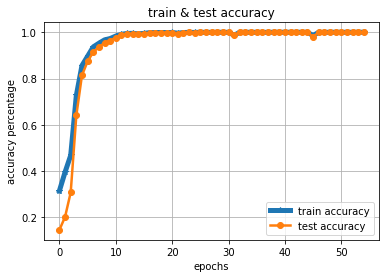

In [26]:
train_line_val = np.array([val.cpu() for val in result_train_acc]) # just replace val with val.cpu() if output is cuda
test_line_val = np.array([val.cpu() for val in result_test_acc]) # just replace val with val.cpu() if output is cuda

train_line, = plt.plot((range(len(train_line_val))), train_line_val, label="train accuracy", marker="*", linewidth=5)
test_line, = plt.plot((range(len(test_line_val))), test_line_val, label="test accuracy", marker="o", linewidth=2.5)
plt.legend(loc="best", handles=[train_line, test_line])
plt.title("train & test accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy percentage")
plt.grid()
plt.show()

In [27]:
torch.save(model, "../data/day_model_saved")
model = torch.load("../data/day_model_saved")

In [28]:
d_test = xtest_day
dt = d_test.copy(deep=True)
d_test = torch.tensor(d_test.values.astype(np.float32))
preds = model(d_test.to(device=device)).argmax(dim=1).cpu()
dt["predicted_days_group_index"] = preds
dt["correct_output"] = ytest_day
dt

,weekday_name,month,month_code,century_code,year_code,leap_year_condition,predicted_days_group_index,correct_output
19729,3,2,3,2,2,1,4,4
18483,5,11,3,2,4,0,3,3
103614,6,7,6,0,0,1,7,7
8841,1,11,3,2,2,0,8,8
97054,5,3,3,2,1,1,6,6
...,...,...,...,...,...,...,...,...
22506,3,9,5,2,6,0,4,4
10317,6,2,3,6,3,1,2,2
5001,0,1,0,0,6,0,8,8
113721,1,8,2,6,5,0,9,9


In [29]:
days_tensor = torch.tensor((xtest_day[["weekday_name", "month", "month_code", "century_code", "year_code", "leap_year_condition"]].values.astype(np.float32)))
preds = model(days_tensor.to(device=device)).argmax(dim=1).cpu()
preds

tensor([4, 3, 7,  ..., 8, 9, 9])

In [30]:
dt.to_csv("../data/day_predections.csv", header=True, index=True)